In [1]:
from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import datetime
import copy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
import time
from sklearn.model_selection import train_test_split
import calendar
from scipy import spatial
import os
import random

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
import sys
sys.path.append('../src/')
import preprocessing_lib as plib
import clustering_lib as clustlib
import exploration_lib as explib
import birch_clustering_lib as birchlib
pd.set_option('max_columns',40)

# Read Table

In [3]:
online_table_location = '../data_folder/Online_Tracker_Feb14/'
online_tracker_ori = plib.read_online_table(online_table_location).query('REL_CMP_PROGRAM_GROUP_NAME != "CAMP/TRP"')

reading from ../data_folder/Online_Tracker_Feb14/


In [4]:
online_tracker_ori.columns.values

array(['ESN', 'EARLIEST_INDICATION_DATE', 'DSID', 'REL_ESN',
       'REL_FAILURE_DATE', 'REL_CMP_SUM_NET_AMOUNT',
       'REL_CMP_SUM_MATERIALS_AMOUNT', 'REL_CMP_SUM_MARKUP_AMOUNT',
       'REL_CMP_SUM_REPAIR_LABOR_AMOUNT',
       'REL_CMP_SUM_OTHER_EXPENSE_AMOUNT', 'REL_CMP_SUM_DEDUCTIBLE_AMOUNT',
       'REL_CMP_PROGRAM_GROUP_CODE', 'REL_CMP_PROGRAM_GROUP_NAME',
       'REL_CMP_PROGRAM_ACCOUNT_CODE', 'REL_CMP_FAIL_DATE_LIST',
       'REL_CMP_CLAIM_DATE_LIST', 'REL_CMP_PAYMENT_DATE_LIST',
       'REL_CMP_IN_SERVICE_DATE_LIST', 'REL_CMP_ESN_LIST',
       'REL_CMP_FAIL_CODE_LIST', 'REL_CMP_FAIL_CODE_DESC_LIST',
       'REL_CMP_DISTRIBUTOR_CODE_LIST', 'REL_CMP_CLAIM_NUM_LIST',
       'REL_CMP_ENGINE_MILES_LIST', 'REL_MINED_DSID_LIST',
       'REL_MINED_FAULT_CODES_LIST', 'DSID_CREATE_DATE',
       'DSID_LAST_UPDATED_DATE', 'GREEN_WRENCH_FAULT_CODE_LIST',
       'GREEN_WRENCH_NUM_LIST', 'GREEN_WRENCH_LIST', 'CSS_INDICATOR_LIST',
       'DSID_CURRENT_STATUS_LIST', 'GREEN_WRENCH_DESC_LIST',

In [5]:
online_tracker_ori.shape

(573444, 409)

# Table Cleaning

In [6]:
feature_dict = {'REL_CMP_FAIL_CODE_LIST': 0.95,
                'GREEN_WRENCH_FAULT_CODE_LIST':0.95,
                'REL_OEM_NAME':0.5,
                #'GREEN_WRENCH_NUM_LIST':0.1,
                'REL_ANALYSIS_RATE_CAT':'specific',
                'REL_CMP_ENGINE_MILES_LIST': 'specific',
                'REL_CMP_FAIL_DATE_LIST':'specific',
                'REL_CMP_SUM_NET_AMOUNT':'impute_take_log',
                #'CMP_SUM_MATERIALS_AMOUNT':'impute_take_log'
                }

transformed_table_whole, clustering_features, clustering_ranges = \
    plib.preprocessing(online_tracker_ori, feature_dict, verbose=True)

Start main table preprocessing
Number of features to create is 7
Replaced Null in list type column REL_CMP_ENGINE_MILES_LIST
Replaced Null in list type column REL_CMP_FAIL_CODE_LIST
Replaced Null in string type column REL_ANALYSIS_RATE_CAT to Unknown
Replaced Null in list type column REL_CMP_FAIL_DATE_LIST
Replaced Null in list type column REL_CMP_CLAIM_DATE_LIST
Replaced Null in list type column GREEN_WRENCH_FAULT_CODE_LIST
Replaced Null in string type column REL_OEM_NAME to Unknown
Replaced Null in list type column GREEN_WRENCH_NUM_LIST
Start Processing Features
Dummify feature REL_CMP_FAIL_CODE_LIST using quantile 0.95


  0%|          | 0/30 [00:00<?, ?it/s]

Create extra features on fail code


100%|██████████| 54/54 [01:18<00:00,  1.45s/it]


Dummify feature GREEN_WRENCH_FAULT_CODE_LIST using quantile 0.95


100%|██████████| 33/33 [00:05<00:00,  5.69it/s]


Dummify feature REL_OEM_NAME using quantile 0.5


  0%|          | 0/3 [00:00<?, ?it/s]

Create Engine Category Feature


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Create Log Miles Feature
Create Log Normalized Age Feature
Imput and take log on REL_CMP_SUM_NET_AMOUNT
Column name of the new feature is REL_CMP_SUM_NET_AMOUNT_IMPUTED_NORMALIZED


In [7]:
transformed_table = transformed_table_whole.loc[transformed_table_whole['INCDT_ISSUE_LABEL'].\
                                              apply(lambda x: x is not None),:]
##Matrix of features values
data = transformed_table.loc[:, clustering_features].values
full_data = transformed_table_whole.loc[:, clustering_features].values

In [8]:
optimal_weights = [2.75, 2.0, 1.0, 4.0, 1.5, 3.75, 2.25, 2.5, 0.25]
n_clusters = 140

# Start Birch Clustering

In [9]:
weighted_data = birchlib.get_weighted_features(data, clustering_ranges, optimal_weights)

In [10]:
start_date = datetime.date(2017, 1, 1)
end_date = datetime.date(2018, 1, 1)
days_skip = 1

birch_clustering_records, clustering_time_stamps = \
    birchlib.birch_clustering(weighted_data, transformed_table, 
                              start_date, end_date, days_skip, 
                              branching_factor = 100000)

100%|██████████| 364/364 [00:17<00:00, 21.32it/s]


In [11]:
# birch_clustering_records.\
#     to_csv('../data_folder/clustering_results/Feb21_Birch_Result_Labeled.csv', index = False)

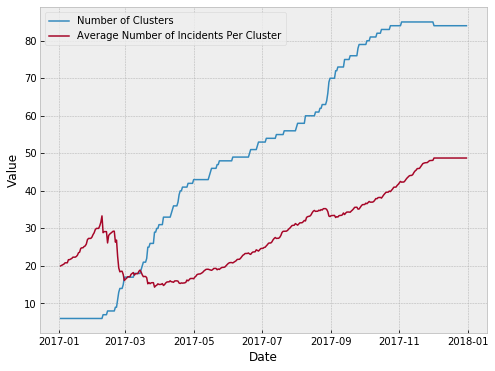

In [12]:
birchlib.birch_cluster_size_plt(birch_clustering_records, clustering_time_stamps)

In [13]:
top_issues = transformed_table.INCDT_ISSUE_LABEL.value_counts().index[1:21]

0


1


2


3


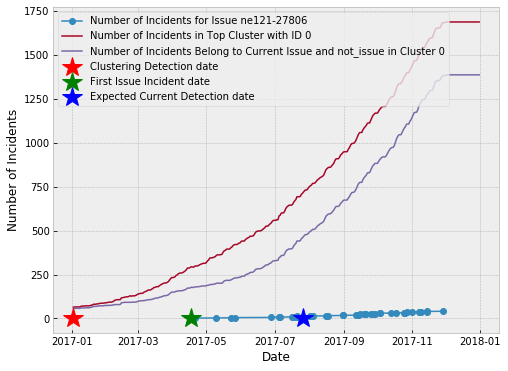

4


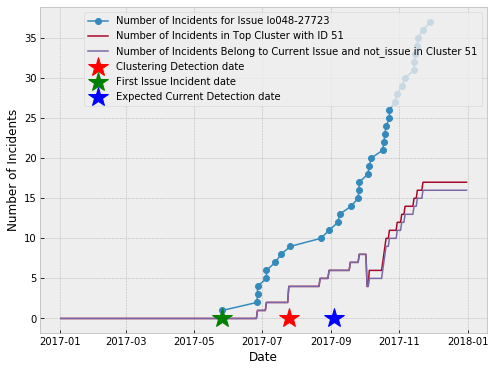

5


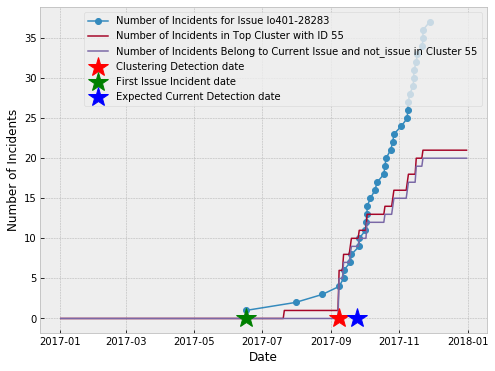

6


7


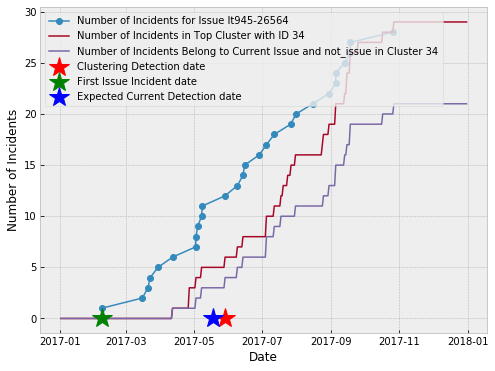

8


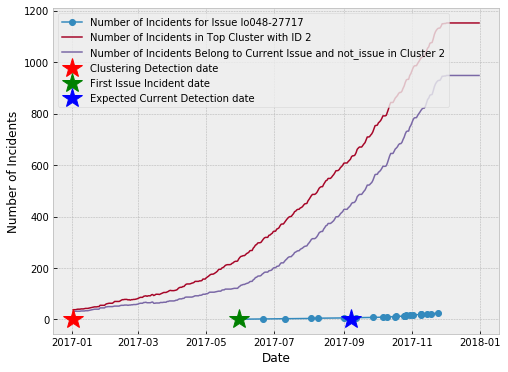

9


10


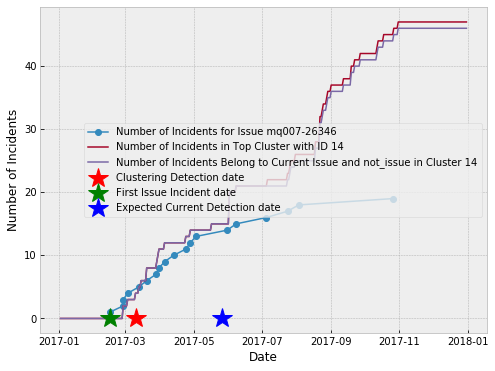

11


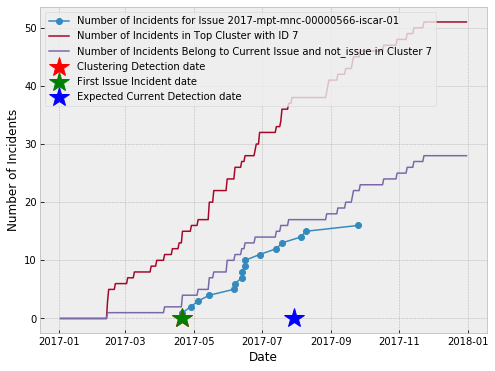

12


13


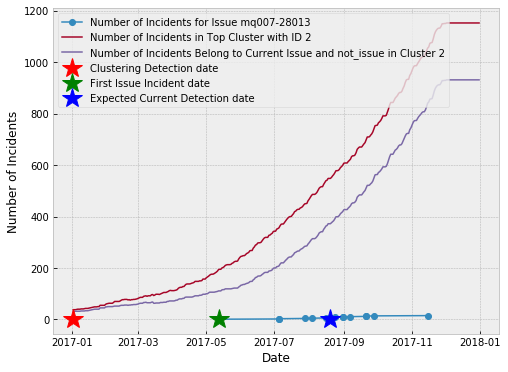

14


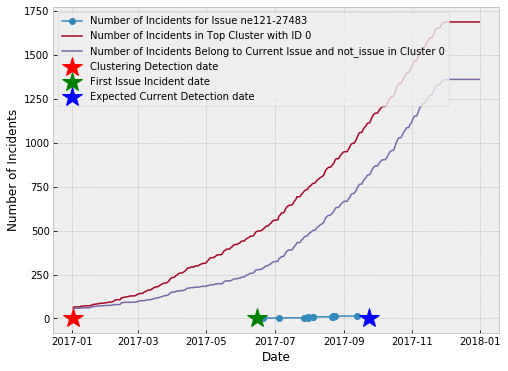

15


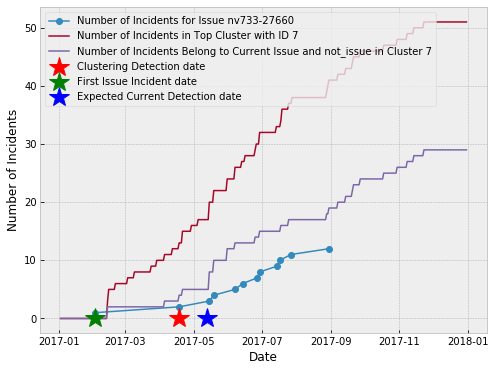

16


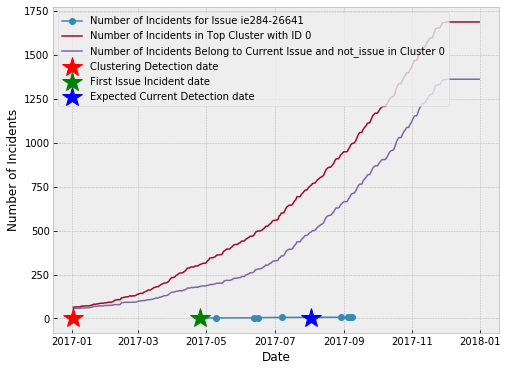

17


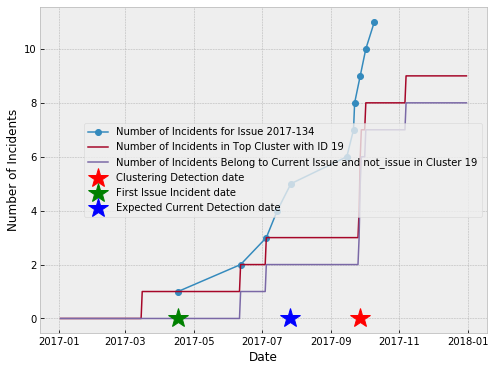

18


19


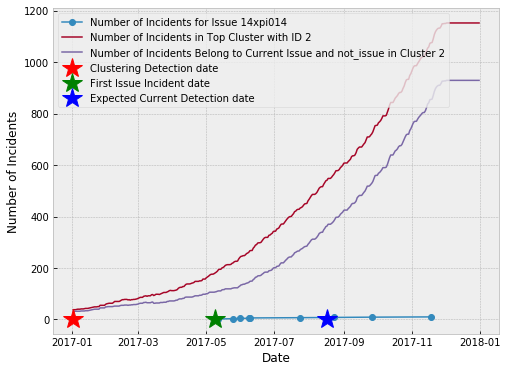

In [14]:
days_detect_earlier = []
tmp_ct = 0
end_date = datetime.datetime.strptime(birch_clustering_records.columns[-1], '%Y-%m-%d').date()
for cur_issue in top_issues:
    print(tmp_ct)
    tmp_ct = tmp_ct + 1
    days_detect_earlier.append(birchlib.plot_cluster_graph(birch_clustering_records,
                                                           transformed_table,
                                                           clustering_time_stamps,
                                                           cur_issue, 
                                                           start_date, 
                                                           end_date, 
                                                           tracking_type = 'final'))

In [15]:
baseline_review_number, fully_review_number, \
        cluster_reviewed, detected_issues, detection_date_df = \
    birchlib.clustering_review_simulation(birch_clustering_records, transformed_table, 
                                 clustering_time_stamps, top_issues, 
                                 incident_detection_size = 5, revisit_size = 10, verbose = False)

100%|██████████| 363/363 [00:07<00:00, 49.64it/s]


In [16]:
detection_date_df

INCDT_ISSUE_LABEL EARLIEST_INDICATION_DATE  \
0                         14xpi014               2017-05-08   
1                         2017-134               2017-04-12   
2   2017-jep-mnc-00001320-escar-01               2017-03-30   
3   2017-mpt-mnc-00000566-iscar-01               2017-04-19   
4                      amyr-ak4qpf               2016-11-30   
5                      gp716-27472               2017-03-07   
6                      ho284-25600               2016-12-30   
7                      ie284-26641               2017-03-20   
8                      jz327-25890               2017-01-20   
9                      lo048-27723               2017-05-26   
10                     lo401-28283               2017-06-06   
11                     lt945-26564               2017-02-07   
12                     mq007-26346               2017-02-14   
13                     mq007-28013               2017-05-12   
14                     ne121-27483               2017-06-12   
15                     nv733-27660               2017-02-01   
16                     ou006-27316               2017-02-09   

   Birch_Detection_Date  Number_of_Incidents Average_Detection_Date  \
0            2017-06-09                   10             2017-08-16   
1            2017-09-27                   11             2017-07-21   
2            2017-04-20                   48             2017-07-08   
3            2017-06-16                   16             2017-07-28   
4            2017-01-02                  296             2017-03-10   
5            2017-04-19                   30             2017-06-15   
6            2017-03-09                   65             2017-04-09   
7            2017-09-28                   11             2017-06-28   
8            2017-02-20                   20             2017-04-30   
9            2017-07-18                   37             2017-09-03   
10           2017-09-08                   37             2017-09-14   
11           2017-05-29                   28             2017-05-18   
12           2017-03-15                   19             2017-05-25   
13           2017-08-31                   15             2017-08-20   
14           2017-08-09                   14             2017-09-20   
15           2017-02-20                   12             2017-05-12   
16           2017-04-27                   15             2017-05-20   

    Days_Detected_Early  
0                    68  
1                   -68  
2                    79  
3                    42  
4                    67  
5                    57  
6                    31  
7                   -92  
8                    69  
9                    47  
10                    6  
11                  -11  
12                   71  
13                  -11  
14                   42  
15                   81  
16                   23

In [17]:
print('Detected ' + str(detection_date_df.shape[0]) + ' in top 20 issues')

Detected 17 in top 20 issues


In [18]:
print('Average date detected earlier is ' + str(detection_date_df.Days_Detected_Early.mean()))

Average date detected earlier is 29.470588235294116


In [19]:
print('Median date detected earlier is ' + str(detection_date_df.Days_Detected_Early.median()))

Median date detected earlier is 42.0


In [20]:
print('Average date detected earlier for positive ones ' + 
      str(detection_date_df.loc[detection_date_df.Days_Detected_Early >= 0, 'Days_Detected_Early'].mean()))

Average date detected earlier for positive ones 52.53846153846154


### Detected Issues and their cluster ID

In [21]:
detected_issues

{'14xpi014': [43, 33],
 '2017-jep-mnc-00001320-escar-01': [38, 38, 37],
 '2017-mpt-mnc-00000566-iscar-01': [52],
 'amyr-ak4qpf': [0, 8, 17, 8, 18, 27, 17, 27],
 'gp716-27472': [25, 28],
 'ho284-25600': [11, 11],
 'ie284-26641': [41],
 'jz327-25890': [10],
 'lo048-27723': [51, 51, 79],
 'lo401-28283': [55, 55, 78, 78],
 'lt945-26564': [34, 34],
 'mq007-26346': [14, 14, 21, 23],
 'mq007-28013': [53],
 'multiple_top_issues': 10,
 'ne121-27483': [58],
 'to_be_reviewed': 23}

### Total Number of Incidents Reviewed

In [22]:
np.sum(fully_review_number)

521

### Cluster ID with their review date and size at that date

In [23]:
cluster_reviewed

{0: [('2017-01-02', 64)],
 1: [('2017-06-22', 6), ('2017-08-09', 11)],
 2: [('2017-01-02', 38)],
 3: [('2017-02-02', 7), ('2017-03-28', 11)],
 4: [('2017-01-02', 10), ('2017-01-06', 11)],
 6: [('2017-04-27', 6)],
 7: [('2017-02-20', 6), ('2017-04-05', 11)],
 8: [('2017-03-14', 6), ('2017-05-02', 11)],
 9: [('2017-04-19', 7), ('2017-08-15', 11)],
 10: [('2017-03-22', 6), ('2017-06-16', 11)],
 11: [('2017-03-09', 6), ('2017-04-27', 11)],
 13: [('2017-06-07', 6), ('2017-10-17', 11)],
 14: [('2017-03-15', 6), ('2017-03-31', 11)],
 17: [('2017-04-11', 6), ('2017-06-22', 11)],
 18: [('2017-03-15', 6), ('2017-05-02', 11)],
 19: [('2017-09-27', 6)],
 21: [('2017-07-05', 6)],
 23: [('2017-07-08', 6), ('2017-09-15', 11)],
 25: [('2017-09-15', 6)],
 26: [('2017-09-26', 6)],
 27: [('2017-05-04', 6), ('2017-07-18', 12)],
 28: [('2017-10-18', 6)],
 29: [('2017-07-18', 6)],
 30: [('2017-10-10', 6)],
 31: [('2017-07-21', 6)],
 33: [('2017-07-25', 6), ('2017-11-15', 11)],
 34: [('2017-05-29', 6), ('201